In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation

In [3]:
X_train_trf1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_train_trf1_v3.csv')
X_val_trf1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_val_trf1_v3.csv')
X_test_trf1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_test_trf1_v3.csv')

#Drop rating_month and rating_year columns
#Drop primaryTitle, userId_ori, movieId_ori

extracted_cols = X_test_trf1.loc[:,['primaryTitle', 'movieId_ori','userId_ori']]

def dropRatingDate(df):
  cols = [0, 1, 2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 42]
  return df.drop(df.columns[cols], axis=1)

X_train_trf1 = dropRatingDate(X_train_trf1)
X_test_trf1 = dropRatingDate(X_test_trf1)
X_val_trf1 = dropRatingDate(X_val_trf1)

columns_list = X_train_trf1.columns.tolist()

X_train_trf1 = X_train_trf1.to_numpy()
X_val_trf1 = X_val_trf1.to_numpy()
X_test_trf1 = X_test_trf1.to_numpy() 

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train_xg_v3.csv').to_numpy(dtype = 'int')
y_val= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_val_xg_v3.csv').to_numpy(dtype = 'int')
y_test= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_test_xg_v3.csv').to_numpy(dtype = 'int')
y_test_ori = y_test

In [4]:
#Convert 9bins to 2bins
def nineToTwoBins(y_dataset):
    for i in range(0, len(y_dataset)): 
        if y_dataset[i] < 6:
            y_dataset[i] = 0
        else:
            y_dataset[i] = 1
    return y_dataset

In [5]:
nineToTwoBins(y_train)
nineToTwoBins(y_val)
nineToTwoBins(y_test)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [6]:
training_data = {'X_train':X_train_trf1,'Y_train':y_train,
                'X_val': X_val_trf1,'Y_val':y_val,
                'X_test': X_test_trf1 ,'Y_test':y_test}

# XGBoost Model

In [7]:
#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=50):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0]))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    #print('XGBoost Precision: '+str(top_k_accuracy_score(training_data['Y_val'], sk_model.predict(training_data['X_val']), k=5)))
    #print('XGBoost Recall: '+str(recall_score(sk_model.predict(training_data['X_val']),training_data['Y_val'])))
    #print('XGBoost ROC_AUC: '+str(roc_auc_score(training_data['Y_val'],sk_model.predict_proba(training_data['X_val'])[:,1])))
    plot_compare(metrics,store,epochs)
    features = columns_list
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()
    
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

Fitting model...
Fitting done!
[0]	val-mlogloss:0.685412	val-merror:0.404853	train-mlogloss:0.685412	train-merror:0.406704
[49]	val-mlogloss:0.623963	val-merror:0.344483	train-mlogloss:0.622557	train-merror:0.341347
-- Model Report --


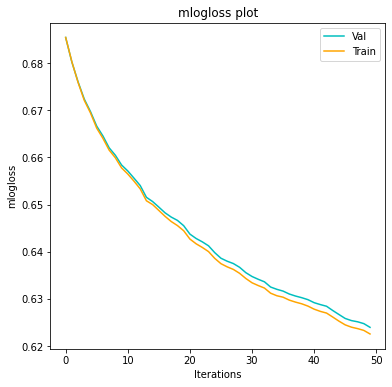

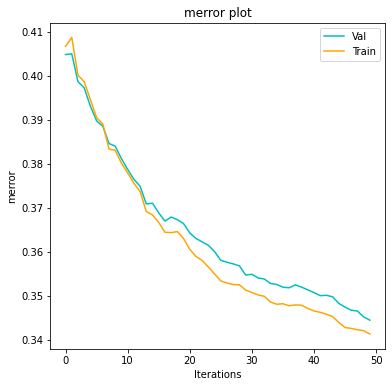

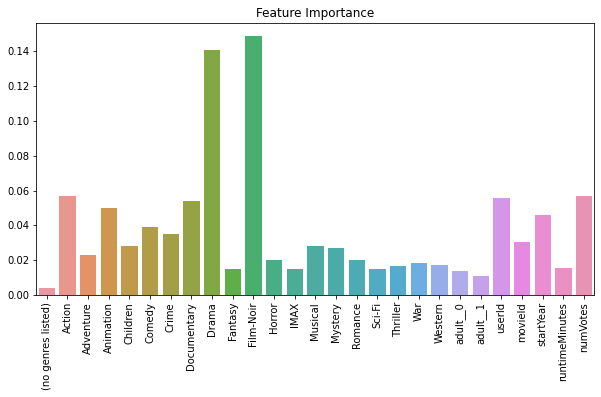

In [ ]:
xgb1 = XGBClassifier(learning_rate=0.2,
                    n_estimators=300,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    tree_method = "gpu_hist",
                    objective='multi:softprob',
                    num_class=2,
                    seed=27)


fitXgb(xgb1, training_data)

# GridSearch Parameter Test

In [ ]:
#GridSearch Param Test Max_Depth and min_child_weight

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train_trf1, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=300, n_jobs=1,
                                     nthread=None, num_class=2,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
             

In [ ]:
getTrainScores(gsearch1)

({0: "mean:0.7545948159349158params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.7549989429147536params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.7548828633468989params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.7780686929629822params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.7778795276597842params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.7780428937245605params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.7885631439863041params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.788919987056944params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.7884728677232948params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.7931504452631961params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.7922562005886814params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.7917316878834464params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.7931504452631961,
  'best_param': {'max_depth': 9, 'min_c

In [ ]:
%%time
xgb2 = XGBClassifier(learning_rate=0.2,
                    n_estimators=300,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    tree_method = "gpu_hist",
                    objective='multi:softprob',
                    num_class=2,
                    seed=27)


fitXgb(xgb2, training_data)

In [ ]:
#Test subsample and colsample_bytree

param_test2 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train_trf1, y_train)

In [ ]:
getTrainScores(gsearch2)

In [ ]:
%%time
xgb3 = XGBClassifier(learning_rate=0.2,
                    n_estimators=300,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.6,
                    tree_method = "gpu_hist",
                    objective='multi:softprob',
                    num_class=2,
                    seed=27)


fitXgb(xgb3, training_data)

In [ ]:
#Test reg_alpha

param_test3 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch2 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train_trf1, y_train)

In [ ]:
getTrainScores(gsearch2)

Reduce learning rate and increase number of estimators

Fitting model...
Fitting done!
[0]	val-mlogloss:0.685242	val-merror:0.362463	train-mlogloss:0.684923	train-merror:0.358535
[49]	val-mlogloss:0.559565	val-merror:0.27795	train-mlogloss:0.544382	train-merror:0.261729
-- Model Report --


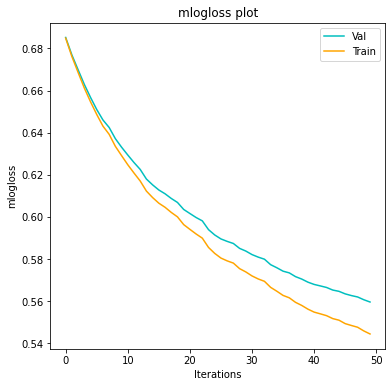

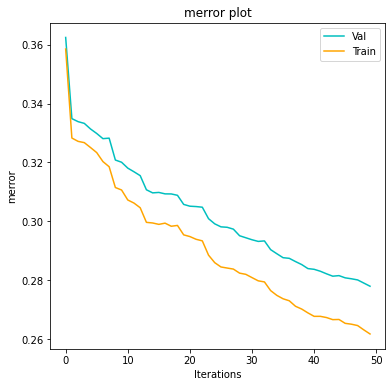

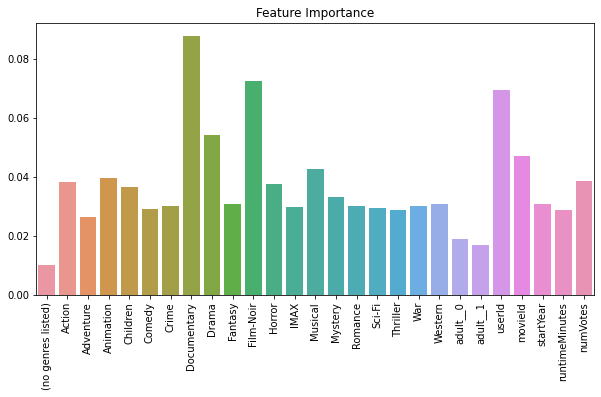

In [8]:
xgb4 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.6,
                    reg_alpha = 0.01,
                    tree_method = "gpu_hist",
                    objective='multi:softprob',
                    num_class=2,
                    seed=27)


fitXgb(xgb4, training_data)

# Metrics

**Hit Ratio**

In [11]:
def hit_ratio(k, extracted_cols, y_test_ori, predictions):

  X_test_complete = extracted_cols
  X_test_complete['prediction'] = predictions
  d = dict(tuple(X_test_complete.groupby(['userId_ori'])))

  Y_test_complete = extracted_cols
  Y_test_complete['actual_rating'] = y_test_ori
  d_true = dict(tuple(Y_test_complete.groupby(['userId_ori'])))

  ratio = []
  for userId in d:
    topk_True = d_true[userId].sort_values(['actual_rating'], ascending = False)[:k]['movieId_ori'].values.tolist()
    topk_pred = d[userId].sort_values(['prediction'], ascending = False)[:k]['movieId_ori'].values.tolist()
    ratio.append(len([x for x in topk_pred if x in topk_True])/k)
  
  #return mean hit ratio
  return pd.Series(ratio).mean()

In [25]:
#input values of k
k = [1, 5, 10, 20, 50, 100]

for i in k:
  print('Hit Ratio @'+ str(i) +' is ' + str(hit_ratio(i, extracted_cols, y_test_ori, xgb4.predict_proba(training_data['X_test'])[:, 1:])))

Hit Ratio @1 is 0.0
Hit Ratio @5 is 0.03297872340425533
Hit Ratio @10 is 0.07765957446808504
Hit Ratio @20 is 0.13882978723404263
Hit Ratio @50 is 0.3020212765957446
Hit Ratio @100 is 0.5013297872340428


**NDCG**

In [36]:
def discountedCumulativeGain(result):
  dcg = []
  for idx, val in enumerate(result): 
      numerator = val
      # add 2 because python 0-index
      denominator =  np.log2(idx + 2) 
      score = numerator/denominator
      dcg.append(score)
  return sum(dcg)

def normalizedDiscountedCumulativeGain(k, result): 
  sorted_result = []
  for i in range(0, k):
    sorted_result.append(1)
  dcg = discountedCumulativeGain(result)
  idcg = discountedCumulativeGain(sorted_result)
  ndcg = dcg / idcg
  return ndcg

def overallNDCG(k, extracted_cols, y_test_ori, predictions):
  X_test_complete = extracted_cols
  X_test_complete['prediction'] = predictions
  d = dict(tuple(X_test_complete.groupby(['userId_ori'])))

  Y_test_complete = extracted_cols
  Y_test_complete['actual_rating'] = y_test_ori
  d_true = dict(tuple(Y_test_complete.groupby(['userId_ori']))) 

  ndcg_lst = []
  for userId in d:
    topk_True = d_true[userId].sort_values(['actual_rating'], ascending = False)[:k]['movieId_ori'].values.tolist()
    topk_pred = d[userId].sort_values(['prediction'], ascending = False)[:k]['movieId_ori'].values.tolist()
    result = []
    for i in range(0, len(topk_pred)):
      if topk_pred[i] in topk_True:
        result.append(1)
      else:
        result.append(0)
    
    ndcg_lst.append(normalizedDiscountedCumulativeGain(k, result))

  return pd.Series(ndcg_lst).mean()

In [37]:
#input values of k
k = [1, 5, 10, 20, 50, 100]

for i in k:
  print('NDCG @'+ str(i) +' is ' + str(overallNDCG(i, extracted_cols, y_test_ori, xgb4.predict_proba(training_data['X_test'])[:, 1:])))

NDCG @1 is 0.0
NDCG @5 is 0.031621049910284846
NDCG @10 is 0.07500688585031674
NDCG @20 is 0.13948297211700902
NDCG @50 is 0.31290762221173235
NDCG @100 is 0.5205108929968485


# Output

In [23]:
output = extracted_cols
predictions = xgb4.predict_proba(training_data['X_test'])[:, 1:]
output['prediction'] = predictions
d = dict(tuple(output.groupby(['userId_ori'])))

def recommendTop10(userId):
  return d[userId].sort_values(['prediction'], ascending = False)['primaryTitle'][:10].reset_index(drop=True)

In [24]:
#Top 10 recommendations for user 1920
recommendTop10(1920)

0                         Braveheart
1    Monty Python and the Holy Grail
2                              Split
3                   Some Like It Hot
4                          Pinocchio
5                       Forrest Gump
6                           Superman
7                            Amadeus
8                      A Quiet Place
9                            Vertigo
Name: primaryTitle, dtype: object